# Spark
## K-means clustering
### Consulting project

In [27]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import findspark

from pyspark import SparkConf
from pyspark import SparkContext

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

from pyspark.ml.clustering import  KMeans

from pyspark.ml.evaluation import ClusteringEvaluator
#from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.classification import GBTClassifier

#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from pyspark.ml.evaluation import BinaryClassificationEvaluator

#from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import seaborn as sns

import optuna

In [11]:
findspark.init()
findspark.find()

%matplotlib inline
sns.set_theme(style='darkgrid')
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

In [12]:
random_seed = 1

In [13]:
conf = SparkConf() \
    .setAppName("cluster-k-means") \
    #.setMaster('local') \
    #.set('spark.executor.memory', '8g') \
    #.set('spark.driver.maxResultSize', '8g') \
    #.set("spark.memory.fraction", "0.6") \
    #.set("spark.memory.storageFraction", "0.5") \
    #.set("spark.sql.shuffle.partitions", "5") \
    #.set("spark.memory.offHeap.enabled", "false") \
    #.set("spark.reducer.maxSizeInFlight", "96m") \
    #.set("spark.shuffle.file.buffer", "256k") \
    #.set("spark.sql.debug.maxToStringFields", "100") \
    #.set('spark.sql.autoBroadcastJoinThreshold', '-1')

In [14]:
%%capture

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [15]:
df = spark.read.format('libsvm').load('../data/sample_kmeans_data.txt')
df.show(5)

23/11/08 14:34:44 WARN LibSVMFileFormat: 'numFeatures' option not specified, determining the number of features by going though the input. If you know the number in advance, please specify it via 'numFeatures' option to avoid the extra scan.


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|           (3,[],[])|
|  1.0|(3,[0,1,2],[0.1,0...|
|  2.0|(3,[0,1,2],[0.2,0...|
|  3.0|(3,[0,1,2],[9.0,9...|
|  4.0|(3,[0,1,2],[9.1,9...|
+-----+--------------------+
only showing top 5 rows



In [18]:
data_input = df.select('features')
data_input.show(5)

+--------------------+
|            features|
+--------------------+
|           (3,[],[])|
|(3,[0,1,2],[0.1,0...|
|(3,[0,1,2],[0.2,0...|
|(3,[0,1,2],[9.0,9...|
|(3,[0,1,2],[9.1,9...|
+--------------------+
only showing top 5 rows



In [16]:
KMeans?

Init signature:
KMeans(
    *,
    featuresCol: str = 'features',
    predictionCol: str = 'prediction',
    k: int = 2,
    initMode: str = 'k-means||',
    initSteps: int = 2,
    tol: float = 0.0001,
    maxIter: int = 20,
    seed: Optional[int] = None,
    distanceMeasure: str = 'euclidean',
    weightCol: Optional[str] = None,
    solver: str = 'auto',
    maxBlockSizeInMB: float = 0.0,
)
Docstring:     
K-means clustering with a k-means++ like initialization mode
(the k-means|| algorithm by Bahmani et al).

.. versionadded:: 1.5.0

Examples
--------
>>> from pyspark.ml.linalg import Vectors
>>> data = [(Vectors.dense([0.0, 0.0]), 2.0), (Vectors.dense([1.0, 1.0]), 2.0),
...         (Vectors.dense([9.0, 8.0]), 2.0), (Vectors.dense([8.0, 9.0]), 2.0)]
>>> df = spark.createDataFrame(data, ["features", "weighCol"])
>>> kmeans = KMeans(k=2)
>>> kmeans.setSeed(1)
KMeans...
>>> kmeans.setWeightCol("weighCol")
KMeans...
>>> kmeans.setMaxIter(10)
KMeans...
>>> kmeans.getMaxIter()
10
>>> km

In [43]:
kmeans = KMeans(
    seed=random_seed,
    featuresCol = 'features',
    k=3,
)

In [44]:
model = kmeans.fit(data_input)

In [45]:
pred = model.transform(data_input)

In [46]:
ClusteringEvaluator?

Init signature:
ClusteringEvaluator(
    *,
    predictionCol: str = 'prediction',
    featuresCol: str = 'features',
    metricName: 'ClusteringEvaluatorMetricType' = 'silhouette',
    distanceMeasure: str = 'squaredEuclidean',
    weightCol: Optional[str] = None,
)
Docstring:     
Evaluator for Clustering results, which expects two input
columns: prediction and features. The metric computes the Silhouette
measure using the squared Euclidean distance.

The Silhouette is a measure for the validation of the consistency
within clusters. It ranges between 1 and -1, where a value close to
1 means that the points in a cluster are close to the other points
in the same cluster and far from the points of the other clusters.

.. versionadded:: 2.3.0

Examples
--------
>>> from pyspark.ml.linalg import Vectors
>>> featureAndPredictions = map(lambda x: (Vectors.dense(x[0]), x[1]),
...     [([0.0, 0.5], 0.0), ([0.5, 0.0], 0.0), ([10.0, 11.0], 1.0),
...     ([10.5, 11.5], 1.0), ([1.0, 1.0], 0.0), (

In [47]:
wssse = model.summary.trainingCost
wssse

0.07499999999994544

In [48]:
model.clusterCenters()

[array([9.1, 9.1, 9.1]), array([0.05, 0.05, 0.05]), array([0.2, 0.2, 0.2])]

In [49]:
results = model.transform(data_input)
results.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|           (3,[],[])|         1|
|(3,[0,1,2],[0.1,0...|         1|
|(3,[0,1,2],[0.2,0...|         2|
|(3,[0,1,2],[9.0,9...|         0|
|(3,[0,1,2],[9.1,9...|         0|
|(3,[0,1,2],[9.2,9...|         0|
+--------------------+----------+



In [62]:
k_list = [_ for _ in range(2, 15)]
wsssse_list = []

for k in k_list:
    
    kmeans = KMeans(
    seed=random_seed,
    featuresCol = 'features',
    k=k,
    )
    
    model = kmeans.fit(data_input)
    
    wssse = model.summary.trainingCost
    wsssse_list.append(wssse)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


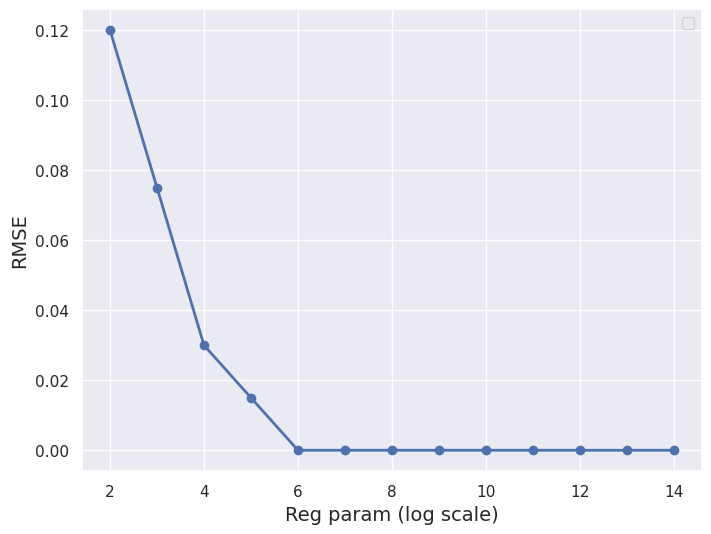

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(k_list, wsssse_list, '-o', linewidth=2)


ax.set_ylabel('RMSE', size=14)
ax.set_xlabel('Reg param (log scale)', size=14)

plt.legend()
plt.show()

In [65]:
best_k = 5

kmeans = KMeans(
seed=random_seed,
featuresCol = 'features',
k=best_k,
)

model = kmeans.fit(data_input)

In [66]:
model.clusterCenters()

[array([9., 9., 9.]),
 array([0.05, 0.05, 0.05]),
 array([0.2, 0.2, 0.2]),
 array([9.2, 9.2, 9.2]),
 array([9.1, 9.1, 9.1])]